# Home Energy Audit

### Technology
- [pydrive](https://towardsdatascience.com/how-to-manage-files-in-google-drive-with-python-d26471d91ecd)
  - I want to protect the privacy of my electricity and thermostat data besides what I share here so I will access from google drive.
  - [How to set up from pydrive doc](https://pythonhosted.org/PyDrive/quickstart.html) and [Setting up the API from Medium post](https://medium.com/@chingjunetao/simple-way-to-access-to-google-service-api-a22f4251bb52), you also need to make sure to enable yourself as a test user, no reason to publish the app.

### Data sources
- [NOAA weather data](https://www.ncei.noaa.gov/pub/data/uscrn/products/hourly02/) (for the Sandstone, MN weather station)
- [Sense electricity data](https://help.sense.com/hc/en-us/articles/360011635634-Web-App-v4)
- [Nest air temp/humidity/runtime data](https://takeout.google.com/settings/takeout)
  - [More info on confusing nest thermostat headers](https://www.reddit.com/r/Nest/comments/9ui8m4/nest_archive_data_confused/)

In [1]:
# OS
import sys, os, pathlib

# Data manipulation
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

# String manipulation
import re

# Plotting
import plotnine as p9
from plotnine import ggplot, aes, geoms, facets, scales, labels, themes

# Local directories
home_dir = pathlib.Path(os.path.realpath("__file__")).parents[0]


In [2]:
from helpers.gauth import make_drive_creds
from helpers.gdrive import make_drive
from helpers.data_prep import get_noaa_data, get_sense_data, get_nest_data


In [3]:
make_drive_creds(home_dir, "home_energy_audit")


Credentials saved to home_energy_audit as my_creds.json


In [4]:
drive = make_drive(home_dir)


### Sense energy monitor data

In [5]:
sense_data = get_sense_data(drive)


In [6]:
display(sense_data.shape, sense_data.dtypes)


(15304, 9)

sense_datetime           datetime64[ns]
sense_device_id                  object
sense_name                       object
sense_device_type                object
sense_device_make                object
sense_device_model              float64
sense_device_location           float64
sense_avg_wattage               float64
sense_kwh                       float64
dtype: object

### Nest thermostat data

In [7]:
nest_sensor_data, nest_summary_data = get_nest_data(drive)


In [8]:
display(nest_sensor_data.shape, nest_sensor_data.dtypes)
display(nest_summary_data.shape, nest_summary_data.dtypes)


(18061, 20)

nest_date             object
nest_time             object
nest_avg_temp        float64
nest_avg_humidity    float64
nest_max_pir         float64
nest_max_nearpir     float64
nest_min_ch1         float64
nest_max_ch1         float64
nest_min_ch2         float64
nest_max_ch2         float64
nest_min_als         float64
nest_max_als         float64
nest_min_tp0         float64
nest_max_tp0         float64
nest_min_tp1         float64
nest_max_tp1         float64
nest_min_tp2         float64
nest_max_tp2         float64
nest_min_tp3         float64
nest_max_tp3         float64
dtype: object

(2148, 10)

nest_start_ts                   datetime64[ns, US/Central]
nest_duration                                       object
nest_event_type                                     object
nest_set_point_type                                 object
nest_set_point_schedule_type                        object
nest_heating_target                                float64
nest_cooling_target                                float64
nest_touched_ts                 datetime64[ns, US/Central]
nest_touched_by                                     object
nest_touched_where                                  object
dtype: object

### NOAA weather data

In [44]:
noaa_data, noaa_readme = get_noaa_data(drive)


In [45]:
display(noaa_data.shape, noaa_data.dtypes)


(4551, 38)

noaa_wbanno                object
noaa_utc_date              object
noaa_utc_time              object
noaa_lst_date              object
noaa_lst_time              object
noaa_crx_vn                object
noaa_longitude             object
noaa_latitude              object
noaa_t_calc               float64
noaa_t_hr_avg             float64
noaa_t_max                float64
noaa_t_min                float64
noaa_p_calc               float64
noaa_solarad                int64
noaa_solarad_flag           int64
noaa_solarad_max            int64
noaa_solarad_max_flag       int64
noaa_solarad_min            int64
noaa_solarad_min_flag       int64
noaa_sur_temp_type         object
noaa_sur_temp             float64
noaa_sur_temp_flag          int64
noaa_sur_temp_max         float64
noaa_sur_temp_max_flag      int64
noaa_sur_temp_min         float64
noaa_sur_temp_min_flag      int64
noaa_rh_hr_avg              int64
noaa_rh_hr_avg_flag         int64
noaa_soil_moisture_5      float64
noaa_soil_mois

In [46]:
print(
    "\n".join(noaa_readme.split("\n")[:31]),
    "\nFile truncated by Henrik for readability...",
)


                          USCRN/USRCRN HOURLY FILES

                            UPDATED: 2017-07-06
                              
README CONTENTS:                          
    1. GENERAL INFORMATION 
    2. DATA VERSION / STATUS UPDATES
    3. DIRECTORY ORGANIZATION
    4. FILE AND FILENAME FORMATS
        A. YEARLY
        B. SNAPSHOTS
        C. UPDATES
    5. DATA FIELDS / FORMATS / IMPORTANT NOTES

********************************************************************************

1. GENERAL INFORMATION

NCDC provides access to hourly data from the U.S. Climate Reference Network / 
U.S. Regional Climate Reference Network (USCRN/USRCRN) via anonymous ftp at:

        ftp://ftp.ncdc.noaa.gov/pub/data/uscrn/products/hourly02
        
and an identical web interface at:

        http://www1.ncdc.noaa.gov/pub/data/uscrn/products/hourly02
        
Before using these data, be sure to review this document carefully, as well
as any announcements within the main (hourly02) directory. 

*****

### Join data for analysis

In [47]:
subset_sense_data = sense_data[
    ["sense_datetime", "sense_name", "sense_avg_wattage", "sense_kwh"]
]
subset_sense_data["sense_name"] = subset_sense_data.sense_name.str.lower().str.replace(
    " ", "_"
)
subset_sense_data["sense_name"] = subset_sense_data.sense_name.apply(lambda x: f"sense_{x}")
subset_sense_data.loc[subset_sense_data.sense_name.isna(), "sense_name"] = "sense_unknown"
subset_sense_data["datetime"] = subset_sense_data.sense_datetime


In [48]:
pivoted_sense_data = pd.pivot(
    subset_sense_data.drop(columns=["sense_datetime"]),
    index="datetime",
    columns="sense_name",
    values="sense_kwh",
)



In [49]:
nest_sensor_data["datetime"] = pd.to_datetime(
    nest_sensor_data.nest_date + " " + nest_sensor_data.nest_time,
    infer_datetime_format=True,
)



In [50]:
nest_data_hourly = (
    nest_sensor_data.set_index("datetime")
    .resample("H")["nest_avg_temp", "nest_avg_humidity"]
    .mean()
    .reset_index()
)



In [51]:
def convert_to_date_time(date, time):
    """Convert NOAA provided date and time integers to a datetime string.

    Args:
        date (str): A date of the form yearmonthday e.g. 20220202.
        time (str): A time of the form hourminute e.g. 2300.

    Returns:
        _type_: _description_
    """
    date = f"{date[:4]}-{date[4:6]}-{date[6:]}"
    time = f"{time[:2]}:{time[2:]}:00"
    return f"{date} {time}"


In [52]:
noaa_data.insert(
    0,
    "datetime",
    pd.to_datetime(
        noaa_data.apply(
            lambda x: convert_to_date_time(x["noaa_lst_date"], x["noaa_lst_time"]),
            axis=1,
        ),
        infer_datetime_format=True,
    ),
)



In [53]:
noaa_data_subset = noaa_data[
    ["datetime", "noaa_t_hr_avg", "noaa_rh_hr_avg", "noaa_solarad"]
]


In [54]:
noaa_data_subset = noaa_data_subset[
    (noaa_data_subset.datetime >= "2022-02-1")
    & (noaa_data_subset.datetime < "2022-07-01")
]



In [55]:
house_data = noaa_data_subset.merge(
    pivoted_sense_data, how="left", on="datetime"
).merge(nest_data_hourly, how="left", on="datetime")



### Explore example data point

In [56]:
daily_fridge_kwh = (
    house_data.set_index("datetime").resample("D").sense_fridge.mean().reset_index()
)


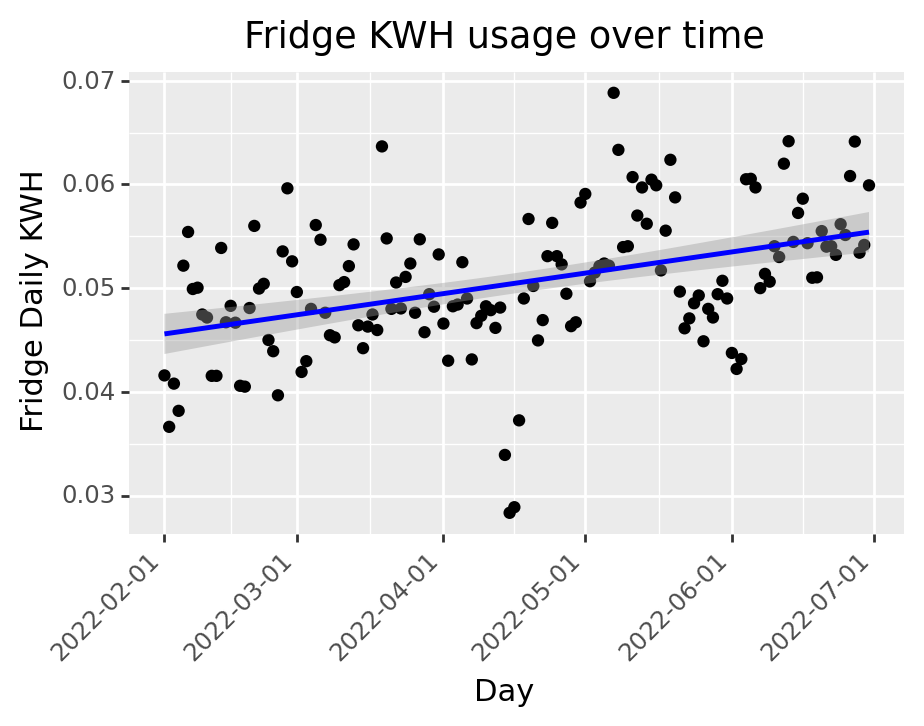

<ggplot: (125544976062)>

In [57]:
p9.options.figure_size = (5, 3)
p9.options.dpi = 200
ggplot(
    daily_fridge_kwh, aes(x="datetime", y="sense_fridge")
) + geoms.geom_point() + geoms.geom_smooth(method="lm", color="blue") + themes.theme(
    axis_text_x=themes.element_text(rotation=45, hjust=1)
) + labels.ggtitle(
    "Fridge KWH usage over time"
) + labels.ylab(
    "Fridge Daily KWH"
) + labels.xlab(
    "Day"
)


### Data quality EDA

In [58]:
house_data = house_data.replace(-9999, np.nan).replace(-99999, np.nan)
house_data.isna().sum()


datetime                       0
noaa_t_hr_avg                 69
noaa_rh_hr_avg              2993
noaa_solarad                  67
sense_always_on                1
sense_coffee_maker          3575
sense_dehumidifier          3302
sense_dryer                 3517
sense_electric_blanket      3586
sense_electric_fireplace    3553
sense_fridge                   8
sense_instant_pot           3548
sense_kettle                3538
sense_microwave             3182
sense_nan                   3543
sense_pump                  2695
sense_total_usage              1
sense_washer                3516
nest_avg_temp                  0
nest_avg_humidity              0
dtype: int64

In [60]:
house_data[
    ["noaa_solarad", "noaa_t_hr_avg", "noaa_rh_hr_avg", "sense_total_usage", "nest_avg_temp", "nest_avg_humidity"]
].describe()



,noaa_solarad,noaa_t_hr_avg,noaa_rh_hr_avg,sense_total_usage,nest_avg_temp,nest_avg_humidity
count,3533.000000,3531.000000,607.000000,3599.000000,3600.000000,3600.000000
mean,169.468723,3.991249,65.477759,0.429986,20.603033,37.365944
std,246.873604,12.774134,19.747893,0.409847,2.454380,8.112938
min,0.000000,-31.400000,19.000000,0.093000,15.303333,20.300000
25%,0.000000,-4.000000,50.000000,0.226000,19.531875,31.691875
50%,9.000000,3.900000,66.000000,0.338000,20.287500,36.856250
75%,275.000000,14.200000,83.000000,0.445500,21.615417,42.911250
max,945.000000,34.200000,98.000000,4.774000,28.460000,65.400000


### Prepare data for modeling

In [61]:
house_data["month"] = house_data.datetime.dt.month_name()
house_data["day_of_week"] = house_data.datetime.dt.day_of_week
house_data["hour"] = house_data.datetime.dt.hour
house_data["trend"] = house_data.datetime.dt.day_of_year


Drop relative humidity because it has too many missing values

In [62]:
X = house_data[
    [
        "month",
        "day_of_week",
        "hour",
        "trend",
        "noaa_solarad",
        "noaa_t_hr_avg",
        "sense_total_usage",
        "nest_avg_temp",
        "nest_avg_humidity",
    ]
]



In [63]:
X = (
    pd.get_dummies(X, columns=["month", "day_of_week", "hour"])
    .rename(columns=lambda x: x.lower())
    .dropna()
)



### Fit regression model

In [64]:
import statsmodels.api as sm


In [67]:
y = X.nest_avg_temp
X = sm.add_constant(X.drop(columns=["nest_avg_temp"]))



In [68]:
lm = sm.OLS(y, X).fit()
lm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          nest_avg_temp   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     202.5
Date:                Sun, 18 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:04:40   Log-Likelihood:                -6145.1
No. Observations:                3530   AIC:                         1.237e+04
Df Residuals:                    3491   BIC:                         1.261e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                10.6563      0.255     41.768      0.000      10.156      11.156
trend                 0.0311      0.003     10.928      0.000       0.026       0.037
noaa_solarad         -0.0003      0.000     -2.036      0.042      -0.001    -1.3e-05
noaa_t_hr_avg         0.0855      0.005     17.118      0.000       0.076       0.095
sense_total_usage     0.0752      0.061      1.234      0.217      -0.044       0.195
nest_avg_humidity     0.0604      0.006     10.523      0.000       0.049       0.072
month_april           0.9886      0.067     14.864      0.000       0.858       1.119
month_february        4.5446      0.136     33.526      0.000       4.279       4.810
month_june            1.3679      0.216      6.323      0.000       0.944       1.792
month_march           2.6730      0.076     35.153      0.000       2.524       2.822
month_may             1.0822      0.133      8.115      0.000       0.821       1.344
day_of_week_0         1.4581      0.070     20.917      0.000       1.321       1.595
day_of_week_1         1.6990      0.067     25.284      0.000       1.567       1.831
day_of_week_2         1.6193      0.067     24.298      0.000       1.489       1.750
day_of_week_3         1.4724      0.068     21.562      0.000       1.339       1.606
day_of_week_4         1.5053      0.067     22.444      0.000       1.374       1.637
day_of_week_5         1.5438      0.069     22.443      0.000       1.409       1.679
day_of_week_6         1.3584      0.069     19.734      0.000       1.223       1.493
hour_0                1.4598      0.116     12.547      0.000       1.232       1.688
hour_1                1.5477      0.119     13.033      0.000       1.315       1.780
hour_2                1.5482      0.120     12.898      0.000       1.313       1.784
hour_3                1.5132      0.119     12.691      0.000       1.279       1.747
hour_4                1.3853      0.119     11.638      0.000       1.152       1.619
hour_5                0.8993      0.119      7.585      0.000       0.667       1.132
hour_6                0.4198      0.119      3.526      0.000       0.186       0.653
hour_7                0.0057      0.115      0.049      0.961      -0.221       0.232
hour_8               -0.3598      0.114     -3.161      0.002      -0.583      -0.137
hour_9               -0.6928      0.115     -6.025      0.000      -0.918      -0.467
hour_10              -0.9926      0.119     -8.373      0.000      -1.225      -0.760
hour_11              -1.1823      0.122     -9.654      0.000      -1.422      -0.942
hour_12              -0.7622      0.126     -6.067      0.000      -1.009      -0.516
hour_13              -0.1865      0.126     -1.478      0.139      -0.434       0.061
hour_14               0.1780      0.126      1.407      0.159      -0.070